In [162]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './2024-datalab-cup2-object-detection/pascal_voc_training_data.txt'
IMAGE_DIR = './2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'
AUG_TRAINING_DATA_PATH = './2024-datalab-cup2-object-detection/pascal_voc_training_data_aug.txt'
AUG_TRAINING_IMAGE_DIR = './2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages_Aug/'
AUG_TRAINING_DATA_IMAGE_NAMES_PATH = './2024-datalab-cup2-object-detection/augmented_image_names.txt'
# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

In [75]:
import tensorflow as tf
import numpy as np
import random

In [20]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

## Processed data format
The information for each image of training data are recorded in VOCdevkit_train/VOC2007/Annotations. However, we have processed those files for you into one record file: pascal_voc_training_data.txt in which each line records informations of each training images.

The data format of pascal_voc_training_data is:

[image_name, xmin, ymin, xmax, ymax, class] (repeat number of objects times)

Elements are separated by space.

### check how many data is in each class

In [165]:
import numpy as np
# store the name of each image
image_names =[]
# store the records of each image
image_names_records= {}
# store the class of each image
image_classes = []

training_data_file = open("./2024-datalab-cup2-object-detection/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    line = line.strip()
    line = line.split(" ")
    img_file = line[0]
    image_names.append(img_file)
    records = [float(num) for num in line[1:]]

    if len(records) > MAX_OBJECTS_PER_IMAGE * 5:
        records = records[:MAX_OBJECTS_PER_IMAGE * 5]
    
    image_names_records[img_file] = np.array(records).reshape((-1, 5))

    image_classes.append(image_names_records[img_file][:, 4].astype(int))


In [166]:
# create lists for every class
class_count = np.zeros(NUM_CLASSES, int)

for objects in image_classes:
    for object in objects:
        class_count[object] += 1

for i in range(NUM_CLASSES):
    print(classes_name[i], class_count[i])

aeroplane 331
bicycle 412
bird 577
boat 398
bottle 612
bus 271
car 1634
cat 389
chair 1423
cow 356
diningtable 309
dog 536
horse 403
motorbike 387
person 5318
pottedplant 603
sheep 353
sofa 419
train 328
tvmonitor 366


In [167]:
augmented_image_names = []
augmented_class_count = np.zeros(NUM_CLASSES, int)
augmented_image_count = np.zeros(len(image_names), int)

for i, image_name in enumerate(image_names):
    augmented_image_names.append(image_name)
    augmented_image_count[i] += 1
    for object in image_classes[i]:
        augmented_class_count[object] += 1


In [168]:
# find classes that have less than 3000 instances
images_to_augment = []
classes_not_to_augment = []
for i in range(NUM_CLASSES):
    if augmented_class_count[i] > 3000:
        classes_not_to_augment.append(i)

for i, image in enumerate(image_names):
    # if the image has an object that is in the classes_not_to_augment list, then don't augment the image
    if any((object in classes_not_to_augment) for object in image_classes[i]):
        continue
    images_to_augment.append(i)

while (augmented_class_count < 3000).any():
    # random select from images_to_augment
    i = random.choice(images_to_augment)
    # count the number of objects that are above the threshold
    object_above_threshold = 0
    for object in image_classes[i]:
        if augmented_class_count[object] >= 3000:
            object_above_threshold += 1
    # if more than half of the objects are above the threshold, then augment the image
    if object_above_threshold < len(image_classes[i])//2:
        image_name = image_names[i].split(".")[0]
        augmented_image_names.append(f'{augmented_image_count[i]}_{image_name}')
        for object in image_classes[i]:
            augmented_class_count[object] += 1
        augmented_image_count[i] += 1


In [169]:
for i in range(NUM_CLASSES):
    print(classes_name[i], augmented_class_count[i])  

aeroplane 3000
bicycle 3001
bird 3000
boat 3001
bottle 3003
bus 3000
car 3159
cat 3000
chair 3778
cow 3001
diningtable 3001
dog 3001
horse 3001
motorbike 3000
person 5318
pottedplant 3046
sheep 3008
sofa 3000
train 3000
tvmonitor 3000


In [170]:
# sort the augmented image names
augmented_image_names.sort()
print(augmented_image_names[:50])

['000005.jpg', '000007.jpg', '000009.jpg', '000012.jpg', '000016.jpg', '000017.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000023.jpg', '000024.jpg', '000026.jpg', '000030.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000039.jpg', '000041.jpg', '000042.jpg', '000044.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000060.jpg', '000061.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000072.jpg', '000073.jpg', '000077.jpg', '000078.jpg', '000081.jpg', '000083.jpg', '000089.jpg', '000091.jpg', '000093.jpg', '000095.jpg', '000099.jpg', '000101.jpg', '000102.jpg', '000104.jpg', '000107.jpg', '000109.jpg']


In [171]:
# store augmented image names into a txt file
augmented_training_data_file = open(AUG_TRAINING_DATA_IMAGE_NAMES_PATH, "w")
for image_name in augmented_image_names:
    augmented_training_data_file.write(image_name + "\n")
augmented_training_data_file.close()

### Data Augmentation
Because the data is not balance, perform data augmentation to make the number of data within each class equal.

In [ ]:
# def random_flip_left_right(image, labels):
#     p = random.random()
#     if p > 0.5:
#         print("flip left right")
#         # Flip the image horizontally
#         image = tf.image.flip_left_right(image)
#         shape = image.shape
#         x_size = shape[1]

#         # Apply the flip to the labels where the object is not all zeros
#         x_min = labels[:, 0]
#         x_max = labels[:, 2]

#         # Flip only the xcenter if the label is not all zeros
#         flipped_x_min = x_size - x_min
#         flipped_x_max = x_size - x_max
        
#         # Stack the new flipped labels
#         flipped_labels = tf.stack([flipped_x_min, labels[:, 1], flipped_x_max, labels[:, 3], labels[:, 4]], axis=1)

#     return image, flipped_labels

# def random_flip_up_down(image, labels):
#     p = random.random()
#     if p > 0.0:
#         print("flip up down")
#         # Flip the image horizontally
#         image = tf.image.flip_left_right(image)
#         shape = image.shape
#         y_size = shape[0]

#         # Apply the flip to the labels where the object is not all zeros
#         y_min = labels[:, 1]
#         y_max = labels[:, 3]

#         flipped_y_min = y_size - y_min
#         flipped_y_max = y_size - y_max
        
#         # Stack the new flipped labels
#         flipped_labels = tf.stack([labels[:, 0], flipped_y_min, labels[:, 2], flipped_y_max, labels[:, 4]], axis=1)

#     return image, flipped_labels

# def data_augmentation(img_file, iter):
#     records = image_name_to_bboxes_dict[img_file]
#     x_min, y_min, x_max, y_max = records[:, 0], records[:, 1], records[:, 2], records[:, 3]
#     class_num = records[:, 4]

#     image_file = tf.io.read_file(IMAGE_DIR+img_file)
#     image = tf.io.decode_jpeg(image_file, channels=3)
#     labels = tf.stack([x_min,y_min, x_max, y_max, class_num], axis=1)
#     print("before", labels)
#     image, labels = random_flip_left_right(image, labels)
#     image, labels = random_flip_up_down(image, labels)
#     print("after", labels)
#     image = tf.image.random_brightness(image, 0.5)
#     image = tf.image.random_contrast(image, 0.5, 2)

#     # store the augmented image
#     image = tf.image.encode_jpeg(image)
#     image_name = img_file.split(".")[0] + "_" + str(iter) + ".jpg"
#     image_path = AUG_TRAINING_IMAGE_DIR + image_name
#     tf.io.write_file(image_path, image)

#     # store the augmented record
#     records = labels.numpy()
#     record_str = ""
#     for record in records:
#         record_str += " ".join([str(int(num)) for num in record]) + " "
#     record_str = image_name + " " + record_str + "\n"

#     with open(AUG_TRAINING_DATA_PATH, "a") as f:
#         f.write(record_str)

# iter = 0
# data_augmentation(class_lists[0][0], iter)

before tf.Tensor(
[[104.  78. 375. 183.   0.]
 [133.  88. 197. 123.   0.]
 [195. 180. 213. 229.  14.]
 [ 26. 189.  44. 238.  14.]], shape=(4, 5), dtype=float64)
flip left right
flip up down
after tf.Tensor(
[[396. 203. 125.  98.   0.]
 [367. 193. 303. 158.   0.]
 [305. 101. 287.  52.  14.]
 [474.  92. 456.  43.  14.]], shape=(4, 5), dtype=float64)


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './2024-datalab-cup2-object-detection/pascal_voc_training_data.txt'
IMAGE_DIR = './2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

## Dataset Loader
We define a class especially to process training data, reading the records from pascal_voc_training_data.txt and follow the steps below to prepare data for our network:

1. Create Dataset using tensorflow data API.
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization).
3. In Dataset map function, change box information [xmin, ymin, xmax, ymax] coordinates into [xcenter, ycenter, width, height] attributes, which is easier for YOLO model to use.
4. Batch, Shuffle operations.

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def random_scale(self, image, labels):
        pass
    def random_crop(self, image, labels):
        pass
    def random_rotate(self, image, labels):
        pass

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
        image, labels = self.random_flip_left_right(image, labels)
        image, labels = self.random_flip_up_down(image, labels)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

## Objection Detection Model(YOLO)
Different from Region Proposal based model, YOLO divide an image into cell_size × cell_size (say 7 × 7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.

### Intersection Over Union(IoU)
The loss calculation of YOLO includes calculating the intersection over union between the predicted boxes and the ground truth boxes. IoU is a common way to evaluate whether the predicted box coordinate is precise enough or not.

### Model Architecture
24 convolution layers followed by 2 fully connected layers.
Use a linear activation function for the final layer and all other layers use the following leaky rectified linear activation:

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [12]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [13]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 192)     110784    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 192)     0         
                                                              

## Define Loss

In [11]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [12]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [13]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

## Start Training

In [42]:
dataset = DatasetGenerator().generate()
print(iter(dataset).next())

(<tf.Tensor: shape=(8, 448, 448, 3), dtype=float32, numpy=
array([[[[-0.1049723 , -0.3481096 , -0.59124684],
         [-0.08746505, -0.3306023 , -0.5737395 ],
         [-0.06540668, -0.3130955 , -0.5562328 ],
         ...,
         [-0.01074928, -0.32776606, -0.5653361 ],
         [ 0.00255597, -0.33196777, -0.5802171 ],
         [-0.00346637, -0.3407213 , -0.5917017 ]],

        [[-0.09039629, -0.33353353, -0.5766708 ],
         [-0.07669348, -0.31983072, -0.562968  ],
         [-0.05054325, -0.29823208, -0.5413693 ],
         ...,
         [-0.00723249, -0.33767503, -0.57029057],
         [ 0.00341868, -0.33369303, -0.5810797 ],
         [ 0.00120056, -0.33605438, -0.5870347 ]],

        [[-0.07263607, -0.31577337, -0.5589106 ],
         [-0.05882573, -0.30196297, -0.5451002 ],
         [-0.03279114, -0.28047997, -0.52361727],
         ...,
         [-0.00127453, -0.33954477, -0.5692717 ],
         [ 0.00945175, -0.3291688 , -0.57605255],
         [ 0.01283193, -0.33012885, -0.578256

In [15]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [16]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

In [17]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [18]:
from datetime import datetime

In [19]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2024-11-10 15:16:00.191765, start training.
2024-11-10 15:19:10.844554, Epoch 1: loss 1438.91
Saved checkpoint for epoch 1: ./ckpts/YOLO\yolo-1
2024-11-10 15:22:11.309287, Epoch 2: loss 21.47
Saved checkpoint for epoch 2: ./ckpts/YOLO\yolo-2
2024-11-10 15:25:10.317213, Epoch 3: loss 20.87
Saved checkpoint for epoch 3: ./ckpts/YOLO\yolo-3


## Predict Test Data
After training, we should run testing on the test data images. Since we should output a txt file in similar format as pascal_voc_training_data.txt, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].

### Process YOLO's predictions
Below is the function process the output of the YOLO network and return the most confident box and its corresponding class and confidence score.

In [18]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

## Build Test Dataset Iterator

In [27]:
test_img_files = open('./2024-datalab-cup2-object-detection/pascal_voc_testing_data.txt')
test_img_dir = './2024-datalab-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [15]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-3')

In [16]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

## Make Prediction and Output to txt file
To run the evaluation program we provide, you should output your prediction with this format(similar but different with pascal_voc_training_data.txt)  

Note: it is also acceptable if there are multiple lines with same image name(different box predictions).

In [30]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

## Run Evaluation Metric
Finally, you can use following example code to run the evaluation program we provide and output the csv file. Please submit the csv file onto Kaggle.

The evaluation program calculates mean Average Precision(mAP) of your output boxes. It will first sort your prediction by your confidence score, and get the Precision/Recall curve:

Then the area under this curve is the mAP of this class.
We separated test data into 10 groups, and calculates the mAP of each class for each group. Your goal is to maximize the total mAP score

In [1]:
import sys
sys.path.insert(0, './2024-datalab-cup2-object-detection/evaluate')

In [2]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


## Visualization
Here we provide a simple code to draw the predicted bounding box and class onto the image and visualize using matplot.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

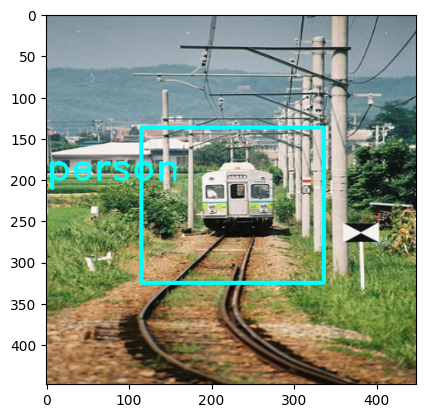

In [21]:
np_img = cv2.imread('./2024-datalab-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()